In [9]:
%matplotlib inline

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



PyTorch를 이용하여 뉴럴 변환(Neural Transfer)
=============================


**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_

**Edited by**: `Winston Herring <https://github.com/winston6>`_

**번역**: `정재민 <https://github.com/jjeamin>`_

소개
------------

이번 튜토리얼은 Leon A. Gatys, Alexander S. Ecker and Matthias Bethge에 의해 개발된
`뉴럴 스타일(Neural-Style) 알고리즘 <https://arxiv.org/abs/1508.06576>`__ 을 구현하는 방법에 대하여 설명합니다.
뉴럴 스타일(Neural-Style), 또는 뉴럴 변환(Neural-Transfer)을 사용하면 이미지를 새로운 예술적 스타일로 재현할 수 있습니다.
이 알고리즘은 입력 이미지, Content 이미지, Style 이미지 3개의 이미지를 가져와서 Content 이미지의 Content와 Style 이미지의 예술적 Style을 닮도록 입력을 변환합니다.

.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1


기본 원리
--------------------

원리는 간단합니다.
Content($D_C$)와 Style($D_S$)에 대해 하나씩 두 개의 거리를 정의합니다. 
$D_C$ 는 두 이미지 간의 Content의 차이를 측정하고 $D_S$ 는 두 이미지 간의 Style의 차이를 측정합니다.
그런 다음, 입력으로 사용되는 세 번째 이미지를 가져와서
Content 이미지로 Content 거리와 Style 이미지로 Style 거리를 최소화하도록 변환합니다.
이제 필요한 패키지를 가져와서 뉴럴 변환(neural transfer)을 시작할 수 있습니다.

패키지 불러오기 및 장치 선택
-----------------------------------------
다음은 뉴럴 변환(neural transfer)을 구현하는데 필요한 패키지 목록입니다.

-  ``torch``, ``torch.nn``, ``numpy`` (PyTorch로 신경망을 구현하기 위한 필수 패키지)
-  ``torch.optim`` (효율적인 경사 하강법)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (이미지 불러오기 및 이미지 표시)
-  ``torchvision.transforms`` (PIL 이미지를 텐서로 변환)
-  ``torchvision.models`` (미리 학습된 모델 불러오기 및 학습)
-  ``copy`` (모델을 복사; 시스템 패키지)



In [11]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

다음으로, 네트워크를 실행 할 장치를 선택하고 Style 이미지와 Content 이미지를 가져와야 합니다.
큰 이미지로 뉴럴 변환(neural transfer) 알고리즘을 실행하면 시간이 오래 걸리고
GPU에서 실행할 때 훨씬 빨라집니다.
``torch.cuda.is_available()`` 를 사용하여 GPU를 이용할 수 있는지 알 수 있습니다.
다음으로, 튜토리얼 전체에서 사용 할 ``torch.device`` 를 설정합니다.
또한 ``.to(device)`` 메소드는 텐서 또는 모듈을 원하는 장치로 이동하는데 사용됩니다.



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

이미지 불러오기
------------------

지금 Style, Content 이미지를 가져올 것입니다. 원본 PIL 이미지는 0과 255 사이의 값을 갖지만,
텐서로 변환될 때 0에서 1사이로 변환됩니다.
이미지도 동일한 차원을 가지도록 크기가 변환되어야 합니다.
주목해야 할 중요한 세부사항은 torch 라이브러리의 신경망은 0에서 1사이의 텐서 값으로 훈련된다는 것입니다.
만약 0에서 255값을 가지는 텐서 이미지가 네트워크에 입력되는 경우,
활성화 된 특징 맵이 Content와 Style을 감지할 수 없습니다.
그러나, Caffe 라이브러리의 미리 학습된 네트워크는 0에서 255값을 가지는 입력으로 훈련됩니다.


.. Note::
    튜토리얼을 실행하는데 필요한 이미지를 다운로드 할 수 있는 주소는 다음과 같습니다.
    `picasso.jpg <https://tutorials.pytorch.kr/_static/img/neural-style/picasso.jpg>`__ 와
    `dancing.jpg <https://tutorials.pytorch.kr/_static/img/neural-style/dancing.jpg>`__.
    두 이미지를 다운로드하고 현재 작업 폴더의 ``images`` 폴더에 추가하세요.



In [13]:
# 원하는 출력 이미지의 크기
imsize = 512 if torch.cuda.is_available() else 128  # 만약 GPU가 없을 경우 작은 크기를 사용

loader = transforms.Compose([
    transforms.Resize(imsize),  # 가져온 이미지 크기 조정
    transforms.ToTensor()])  # 텐서로 변환


def image_loader(image_name):
    image = Image.open(image_name)
    # 네트워크의 입력 차원에 맞추기 위해 필요한 가짜 배치 차원
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/drive/MyDrive/neural style/반고흐.jpg")
content_img = image_loader("/content/drive/MyDrive/neural style/나.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

이제 이미지를 PIL 형식으로 다시 변환하고 ``plt.imshow`` 를
사용해 이미지를 표시하는 함수를 만들겠습니다.
Content와 Style 이미지를 표시하여 올바르게 가져왔는지 확인합니다.



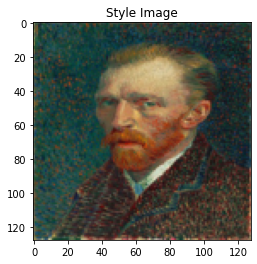

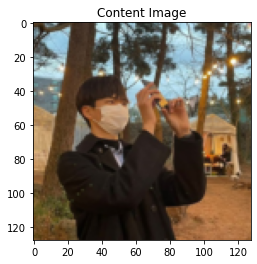

In [14]:
unloader = transforms.ToPILImage()  # PIL 이미지로 다시 변환

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서를 복제하여 변경하지 않음
    image = image.squeeze(0)      # 가짜 배치 차원 제거
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plots가 업데이트 되도록 잠시 멈춤


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

손실 함수
--------------
콘텐츠 손실(Content Loss)
~~~~~~~~~~~~

Content 손실은 각 계층에 대한 Content 거리의 가중치 버전을 나타냅니다.
이 함수는 입력 $X$ 를 처리하는 레이어 $L$ 의 특징 맵 $F_{XL}$ 을 가져와서
이미지 $X$ 와 Content 이미지 $C$ 사이의
가중 콘텐츠 거리(weighted content distance) $w_{CL}.D_C^L(X,C)$ 를 반환합니다.
Content 거리를 계산하기 위해 Content 이미지($F_{CL}$)의 특징 맵을 함수에서 알고 있어야합니다.
$F_{CL}$ 을 입력으로 사용하는 생성자를 사용해 이 함수를 torch 모듈로 구현합니다.
거리 $\|F_{XL} - F_{CL}\|^2$ 는 두 개의 특징 맵 집합의 평균 제곱 오차이며 ``nn.MSELoss`` 를 사용하여 계산할 수 있습니다.

Content 거리를 계산하기 위해 사용되는 합성곱 계층 바로 뒤에 Content 손실 모듈을 추가합니다.
이렇게 하면 입력 이미지가 입력될 때마다 Content 손실이 원하는 레이어에서
계산되고 autograd 을 통해 모든 기울기가 계산됩니다.
이제 Content 손실 계층을 만들기 위해 Content 손실을 계산한 다음 계층의 입력을 반환하는
``forward`` 메소드를 정의해야합니다.
계산된 손실은 모듈의 매개 변수로써 저장됩니다.




In [15]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 기울기를 동적으로 계산하는데 사용되는 tree로부터 타깃 Content를 `분리(detach)` 합니다.
        # 이것은 변수가 아니라 명시된 값입니다.
        # 그렇지 않으면 criterion의 forward 메소드에서 오류가 발생합니다.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

.. Note::
   **중요 세부 사항**: 모듈의 이름은 ``ContentLoss`` 지만, 실제 PyTorch의 손실 함수는 아닙니다.
   만약 Content 손실을 PyTorch의 손실 함수로 정의하려면 Pytorch의 autograd 함수를 생성하여
   ``backward`` 메소드에서 수동으로 기울기를 다시 계산 및 구현 해야 합니다.



스타일 손실(Style Loss)
~~~~~~~~~~

Style 손실 모듈은 Content 손실 모듈과 유사하게 구현됩니다.
네트워크에서 해당 계층의 Style 손실을 계산하는 역할을 합니다.
Style 손실을 계산하기 위해서, gram 행렬 $G_{XL}$ 를 계산해야합니다.
gram 행렬은 주어진 행렬에 전치 행렬을 곱한 결과입니다.
이 어플리케이션에서 주어진 행렬은 계층 $L$ 의 특징 맵 $F_{XL}$ 의 재구성된 버전입니다.
$F_{XL}$ 는 $K$\ x\ $N$ 행렬인 $\hat{F}_{XL}$ 을 형성하도록 재구성되며,
$K$ 는 계층 $L$ 의 특징 맵의 수이고 $N$는 벡터화된 특징 맵의 길이입니다.
예를 들어, $\hat{F}_{XL}$ 의 첫 번째 줄은 벡터화된 특징 맵 $F_{XL}^1$ 에 해당합니다.

마지막으로, gram 행렬은 행렬에서 각 값을 값의 총 개수로 나누어 정규화 해야 합니다.
정규화는 큰 $N$ 차원을 가지는 $\hat{F}_{XL}$ 행렬이 gram 행렬에서 더 큰 값을 생성한다는 사실에 대응하기 위한 것입니다.

이와 같은 더 큰 값은 첫 번째 계층(풀링 계층 전)이 경사 하강 중에 더 큰 영향을 미치게합니다.

Style 특징은 네트워크의 깊은 계층에 있는 경향이 있기에 정규화 단계가 중요합니다.




In [16]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=배치 크기(=1)
    # b=특징 맵의 수
    # (c,d)=특징 맵의 차원 (N=c*d)

    features = input.view(a * b, c * d)  # F_XL을 \hat F_XL로 크기 조정

    G = torch.mm(features, features.t())  # gram product를 계산

    # 각 특징 맵이 갖는 값의 수로 나누어
    # gram 행렬의 값을 '정규화'
    return G.div(a * b * c * d)

이제 Style 손실 모듈은 Content 손실 모듈과 거의 똑같아 보입니다.
Style 거리는 $G_{XL}$ 와 $G_{SL}$ 사이의 평균 제곱 오차를 사용해 계산됩니다.




In [17]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

모델 가져오기
-------------------

이제는 사전 훈련된 신경망을 가져와야 합니다.
논문에서 사용된 것과 같이 19 계층을 가진 VGG 네트워크를 사용할 것입니다.

PyTorch의 VGG 구현은 ``features`` (합성곱 및 풀링 계층 포함) 와
``classifier`` (완전 연결 계층 포함) 두 가지 하위 ``Sequential`` 모듈로 구분 된 모듈입니다.
Content 및 Style 손실을 측정하기 위해서 각 합성곱 계층의 출력이 필요하기 때문에 ``features`` 모듈을 사용할 것입니다.
일부 계층은 훈련하는 중 평가와 다른 동작을 하므로, 네트워크를 ``.eval()`` 를 사용해 평가 모드로 설정해야합니다.




In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

추가적으로, VGG 네트워크는
mean=[0.485, 0.456, 0.406] 와 std=[0.229, 0.224, 0.225]로 각 채널이 정규화 된
이미지로 훈련됩니다.
이미지를 네트워크로 입력하기 전에 정규화하는데 사용합니다.




In [19]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 입력 이미지를 정규화하는 모듈을 생성하여 쉽게 nn.Sequential에 넣을 수 있습니다.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view 는 mean과 std을 확인해 [B x C x H x W] 형태의
        # 이미지 텐서를 직접적으로 작업할 수 있도록 [C x 1 x 1] 형태로 만듭니다.
        # B는 배치 크기입니다. C는 채널의 수입니다. H는 높이고 W는 너비입니다.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img 정규화
        return (img - self.mean) / self.std

``Sequential`` 모듈은 순서가 있는 하위 모듈의 리스트가 포함됩니다.
예를 들어, ``vgg19.features`` 은 올바른 순서로 정렬 된
시퀀스(Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…)가 포함되어 있습니다.
Content 손실과 Style 손실 계층을 감지하는 합성곱 계층 바로 뒤에 추가해야합니다.
이렇게 하기 위해서는 Content 손실과 Style 손실 모듈이
올바르게 삽입된 새로운 ``Sequential`` 모듈을 만들어야 합니다.




In [20]:
# Style / Content 손실 계산을 원하는 계층
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 모듈 정규화
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Content / Style 손실이 반복적으로 접근할 수 있도록 하기 위해
    content_losses = []
    style_losses = []

    # cnn이 nn.Sequential이라고 가정하고,
    # 순차적으로 활성화되어야 하는 모듈에 새로운 nn.Sequential을 만듭니다.
    model = nn.Sequential(normalization)

    i = 0  # conv를 볼 때마다 증가
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # in-place 버전은 아래에 삽입한 Content 손실과 Style 손실와 잘 어울리지 않습니다.
            # 그래서 여기서는 out-of-place로 대체합니다.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Content 손실 추가
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Style 손실 추가
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 이제 마지막 Content 및 Style 손실 뒤에 계층을 잘라냅니다.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

다음으로 입력 이미지를 선택합니다. Content 이미지 사본이나 백색 잡음을 사용할 수 있습니다.




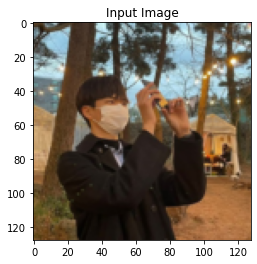

In [21]:
input_img = content_img.clone()
# 만약 화이트 노이즈(white noise)을 사용하려면 아래 주석을 제거하세요
# input_img = torch.randn(content_img.data.size(), device=device)

# 그림에 원본 입력 이미지를 추가합니다.
plt.figure()
imshow(input_img, title='Input Image')

경사 하강법
----------------


알고리즘 작성자인 Leon Gatys가
`여기 <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__ 에서 제안했던 것처럼,
L-BFGS 알고리즘을 사용하여 경사 하강법을 수행합니다.
네트워크 훈련과 다르게 Content / Style 손실을 최소화하기 위해 입력 이미지를 훈련하려고 합니다.
파이토치 L-BFGS optimizer ``optim.LBFGS`` 를 만들고 최적화 할 텐서로 이미지를 전달합니다.




In [22]:
def get_input_optimizer(input_img):
    # 입력이 기울기가 필요한 매개 변수임을 표시하는 줄
    optimizer = optim.LBFGS([input_img])
    return optimizer

마지막으로 뉴럴 변환(neural transfer)을 수행하는 함수를 정의해야 합니다.
네트워크의 각 반복 동안, 업데이트된 입력이 주어지고 새로운 손실을 계산합니다.
각 손실 모듈(Loss module)의 ``backward`` 메소드를 실행하여 기울기를 동적으로 계산합니다.
optimizer는 모듈을 재평가하고 손실을 반환하는 “closure” 함수가 필요합니다.

여전히 해결해야 할 마지막 제약이 있습니다.
네트워크가 이미지에 대해 0 ~ 1 텐서 범위를 초과하는 값으로 최적화하려 할 수 있습니다.
네트워크가 실행될 때마다 입력값을 0에서 1사이로 수정하여 문제를 해결할 수 있습니다.




In [23]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 마지막 수정...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

마지막으로, 알고리즘을 실행합니다.




In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Optimizing..
run [50]:
Style Loss : 38.721073 Content Loss: 25.255676

run [100]:
Style Loss : 16.559851 Content Loss: 21.151093

run [150]:
Style Loss : 10.484133 Content Loss: 18.408180

